In [1]:
#needed for get_extinction to work
import xml.etree.ElementTree as ET
import requests
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy import units as u
from astropy.coordinates import SkyCoord 

#needed for plotting
import matplotlib.pyplot as plt

In [2]:
def get_extinction_area(ra, dec, size=5):
    #searching for region of certain size
    base = "https://irsa.ipac.caltech.edu/cgi-bin/DUST/nph-dust?"
    search = f"locstr={ra}+{dec}+equ+j2000&regSize={size}"
    url = base+search
    r = requests.get(url)
    content = r.content
    #reading xml file
    tree = ET.ElementTree(ET.fromstring(content))
    root = tree.getroot()
    #getting image url to download
    img_url = root[1].find("data").find("image").text[9:-7]
    #opening and getting fits image data
    with fits.open(img_url, use_fsspec=True) as hdul:
        wcs = WCS(hdul[0].header)
        header = wcs.to_header()
        image_data = hdul[0].data
    #returning
    return image_data, wcs, header

In [3]:
def get_pix(ra, dec, wcs):
    #chage list of coords to astropy skycoords
    coords = SkyCoord(ra, dec, unit="deg")
    #getting their respective pixels
    x, y = skycoord_to_pixel(coords, wcs)
    #changing to int
    x = x.astype(int)
    y = y.astype(int)
    return x, y

In [4]:
def get_extinction_point(x, y, image):
    #list to append result to
    extinction = list()
    #get extinction for each location
    for x_px, y_px in zip(x,y):
        #if the pix vals are negative outside image region
        if x_px < 0 or y_px < 0:
            raise ValueError(f"No Data for Pixel {x_px}, {y_px} in image")
        #else continue as normal and get pixel data
        reddening = image[x_px, y_px]
        #append and return
        extinction.append(reddening)
    return extinction

## Test Run

In [5]:
ra = [10,10.5]
dec = [10,10]

In [6]:
image_data, wcs, header = get_extinction_area(10,10,2)

In [7]:
x_pix, y_pix = get_pix(ra, dec, wcs)

In [8]:
extinction = get_extinction_point(x_pix, y_pix, image_data)

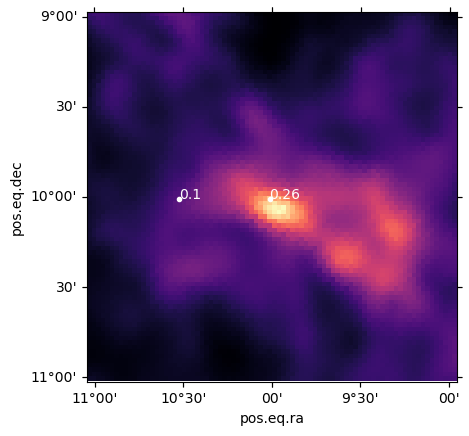

In [13]:
fig, axs = plt.subplots(subplot_kw={'projection': wcs})

axs.coords[0].set_format_unit(u.deg)
axs.coords[1].set_format_unit(u.deg)


axs.imshow(image_data, origin="lower", cmap="magma")
axs.plot(x_pix, y_pix, "w.")

for i, val in enumerate(extinction):
    axs.annotate(round(val,2), [x_pix[i], y_pix[i]], c="w")
plt.show()